# Generate

Generate data to augment the original dataset

## Imports:

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import numpy as np
import datetime

from sdv.tabular import CTGAN
import table_evaluator as te

IPython not installed.


In [3]:
import mvi.utils as mvi_utils
import mvi.model.vae as vae 

## Config

In [4]:
USE_VAE = False  # False -> use CTGAN
RETRAIN_MODEL = False
SAVE_MODEL = False
SAVE_DATA = False

In [5]:
SYNTHETIC_DATA_SIZE = 10_000

HPARAMS_CTGAN = {
    "epochs": 300,
    "log_frequency": False,
    "verbose": True,
}
HPARAMS_VAE = {
    "dim_latent": 4,
    "verbose": True,
    "epochs": 100,
}

HPARAMS = HPARAMS_VAE if USE_VAE else HPARAMS_CTGAN

In [6]:
MODEL_DIR_PATH = "../model/"

MODEL_NAME = "vae" if USE_VAE else "ctgan"
PATH_MODEL_DEFAULT = os.path.join(MODEL_DIR_PATH, f"{MODEL_NAME}.pkl")

In [7]:
DATA_DIR_PATH = "../data/"

PATH_PREPROCESSED = os.path.join(DATA_DIR_PATH, "train_preprocessed.csv")
PATH_SYNTH = os.path.join(DATA_DIR_PATH, f"train_synth_{MODEL_NAME}.csv")

## Read data

Only the training data are augmented.

In [8]:
def _read_data_preprocessed(path: str) -> pd.DataFrame:
    return pd.read_csv(path, parse_dates=["timestamp"])

In [9]:
df_preprocessed = _read_data_preprocessed(PATH_PREPROCESSED)
df_preprocessed.head(1)

id  price_doc  timestamp  full_sq  life_sq  floor  max_floor  material  \
0  148   14103600 2011-10-18      117    108.0   20.0  13.257777        -1   

    build_year  num_room  kitch_sq  state    cpi  employment   salary  \
0  1493.741935  1.801699  3.183089     -1  353.0       0.708  44898.7   

   salary_growth  deposits_value  mortgage_rate  
0       0.168917        10920215          11.57

## Prepare data

Data preparation for the augmentation (making all columns compatible).

In [10]:
date_encoder = mvi_utils.DateEncoder()

Steps:

In [11]:
def _encode_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    return df_preprocessed.assign(**{
        "timestamp": date_encoder.encode(df_preprocessed.timestamp)
    })


def _drop_ids(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop("id", axis=1)

Apply steps:

In [12]:
df_prepared = (df_preprocessed
               .transform(_encode_timestamp)
               .transform(_drop_ids)
              )

## Train generative model

In [13]:
def _save_model(model):
    """Saves model to local storage"""
    print(f"Saving model to path: `{PATH_MODEL_DEFAULT}`")
    mvi_utils.mkdir_safe(MODEL_DIR_PATH)
    model.save(PATH_MODEL_DEFAULT)
    
    
def _get_model(train_data: pd.DataFrame, retrain: bool = RETRAIN_MODEL):
    """Retrives generative model"""
    model_class = vae.VAE if USE_VAE else CTGAN
    if not retrain:
        print(f"Loading model from path: `{PATH_MODEL_DEFAULT}`")
        return model_class.load(PATH_MODEL_DEFAULT)
    
    print(f"Retraining model with hypeparameters: {HPARAMS}")
    model = model_class(**HPARAMS)
    model.fit(train_data)
    return model

Train or load the generative model:

In [14]:
synthesizer = _get_model(train_data=df_prepared)

Loading model from path: `../model/ctgan.pkl`


In [15]:
if SAVE_MODEL:
    _save_model(synthesizer)

Use the model to generate new data (convert all columns to the original format):

## Generate new data 

In [16]:
def _generate_data(model, n_samples: int = SYNTHETIC_DATA_SIZE) -> pd.DataFrame:
    """Uses passed model to generate new samples"""
    return model.sample(n_samples)
    
    
def _decode_dates(df: pd.DataFrame, col_name: str = "timestamp") -> pd.DataFrame:
    """Decodes timestamp"""
    return df.assign(**{
        col_name: pd.to_datetime(date_encoder.decode(df.loc[:, col_name]))
    })


def _mock_ids(df: pd.DataFrame, id_first: int, id_col: str = "id") -> pd.DataFrame:
    """Appends column of mocked IDs"""
    ids_gen = np.arange(id_synth_first, id_synth_first + df_synth_raw.shape[0])
    return df.assign(**{id_col: pd.Series(ids_gen, dtype="int64")})


def _set_main_columns(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """Changes columns order, always starting with the main columns"""
    cols_first = [col for col in df.columns if col in cols]
    cols_other = [col for col in df.columns if col not in cols]
    
    return df.loc[:, [*cols_first, *cols_other]]

In [17]:
df_synth_raw = _generate_data(synthesizer)
df_synth_raw

price_doc  timestamp  full_sq    life_sq     floor  max_floor  material  \
0       7602099        991       48   0.000000  8.827061       13.0         1   
1       8439539       1345       49  49.552223  7.325498        1.0         1   
2      14042341        942       49  74.805416  9.708631       17.0         1   
3       4322333        447       59  49.669251  8.176651       13.0         0   
4       5812158        406       69  16.004025  8.015887       13.0         0   
...         ...        ...      ...        ...       ...        ...       ...   
9995    2602812        730       43  49.590183  2.106337       25.0         1   
9996   10538791       1373       40  49.623173  1.883315       13.0         1   
9997   11927444        359       50  17.158618  4.665327       13.0         0   
9998    5211100        584       37  16.553169  8.560828       13.0         0   
9999    8593765       1128       86  49.658913  3.044911        4.0         1   

       build_year  num_room  kitch_sq  state    cpi  employment   salary  \
0     2017.997663       3.0       1.0      1  415.0    0.739809  61187.1   
1     1490.725493       2.0       0.0      1  484.3    0.733272  64310.0   
2     2011.806810       2.0       1.0      1  408.2    0.717096  55500.1   
3     1494.209648       2.0       3.0      0  375.9    0.716260  48888.0   
4     1496.005255       2.0       3.0      0  375.9    0.716176  48953.8   
...           ...       ...       ...    ...    ...         ...      ...   
9995  1495.200482       1.0       1.0      1  397.9    0.718403  55473.6   
9996  1492.488788       2.0       0.0      1  488.1    0.734118  64260.0   
9997  1494.528864       2.0       3.0      0  372.6    0.716733  48847.7   
9998  1495.176517       2.0       3.0      0  395.9    0.718235  55481.4   
9999  1497.227492       2.0       1.0      0  428.8    0.740000  61196.6   

      salary_growth  deposits_value  mortgage_rate  
0          0.103640        16749652          12.27  
1          0.052205        19383170          14.05  
2          0.103261        15980675          12.29  
3          0.087797        13381495          12.59  
4          0.087854        13515991          12.55  
...             ...             ...            ...  
9995       0.136476        16071818          11.96  
9996       0.050680        19383170          13.48  
9997       0.087206        13177569          12.29  
9998       0.136752        14450427          12.64  
9999       0.103752        17101123          12.43  

[10000 rows x 17 columns]

In [18]:
id_synth_first = df_preprocessed.id.max() + 1

df_synth = (df_synth_raw
            .transform(_decode_dates)
            .transform(_mock_ids, id_first=id_synth_first)
            .transform(_set_main_columns, cols=["id"])
           )

In [19]:
mvi_utils.check_schema(df_preprocessed, df_synth, verbose=True)

All schemas match.


## Comparison

In [20]:
cols_cat = [
    "material",
    "state",
]

In [21]:
def _prepare_for_evaluation(df: pd.DataFrame) -> pd.DataFrame:
    """Transforms dataframe so that its compatible with `TableEvaluator`"""
    return df.drop(["timestamp", "id"], axis=1)

In [22]:
df_real_cmp = df_preprocessed.transform(_prepare_for_evaluation)
df_synth_cmp = df_synth.transform(_prepare_for_evaluation)

evaluator = te.TableEvaluator(real=df_real_cmp, fake=df_synth_cmp, cat_cols=cols_cat)

Metrics:

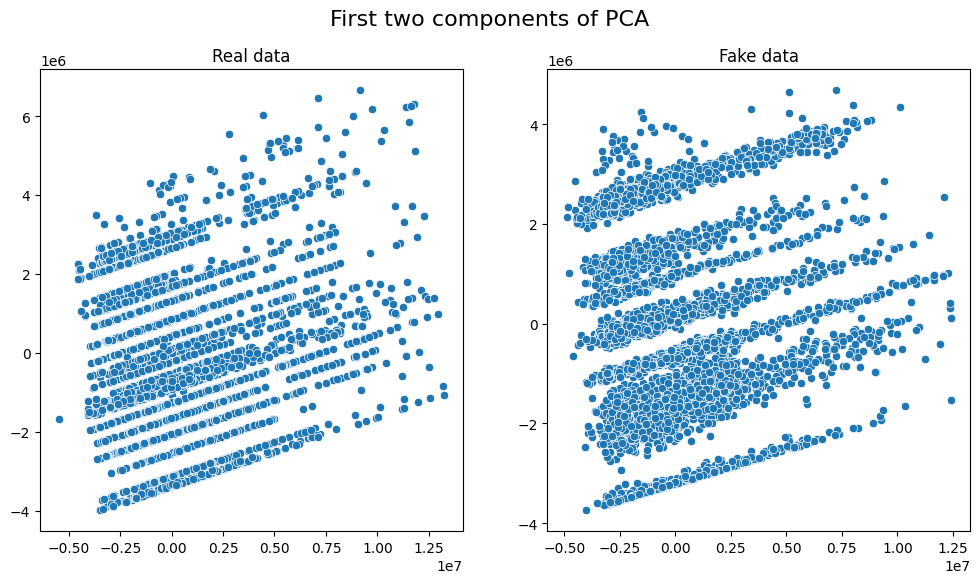

In [23]:
evaluator.plot_pca()

Plots:

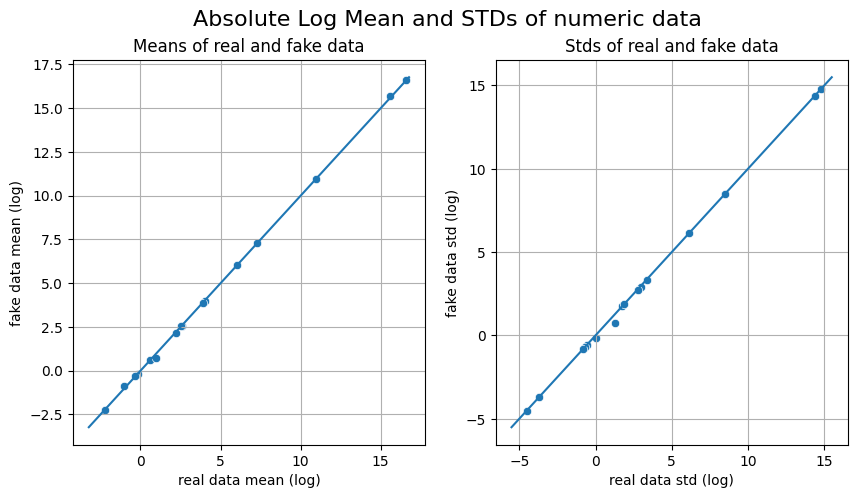

In [24]:
evaluator.plot_mean_std()

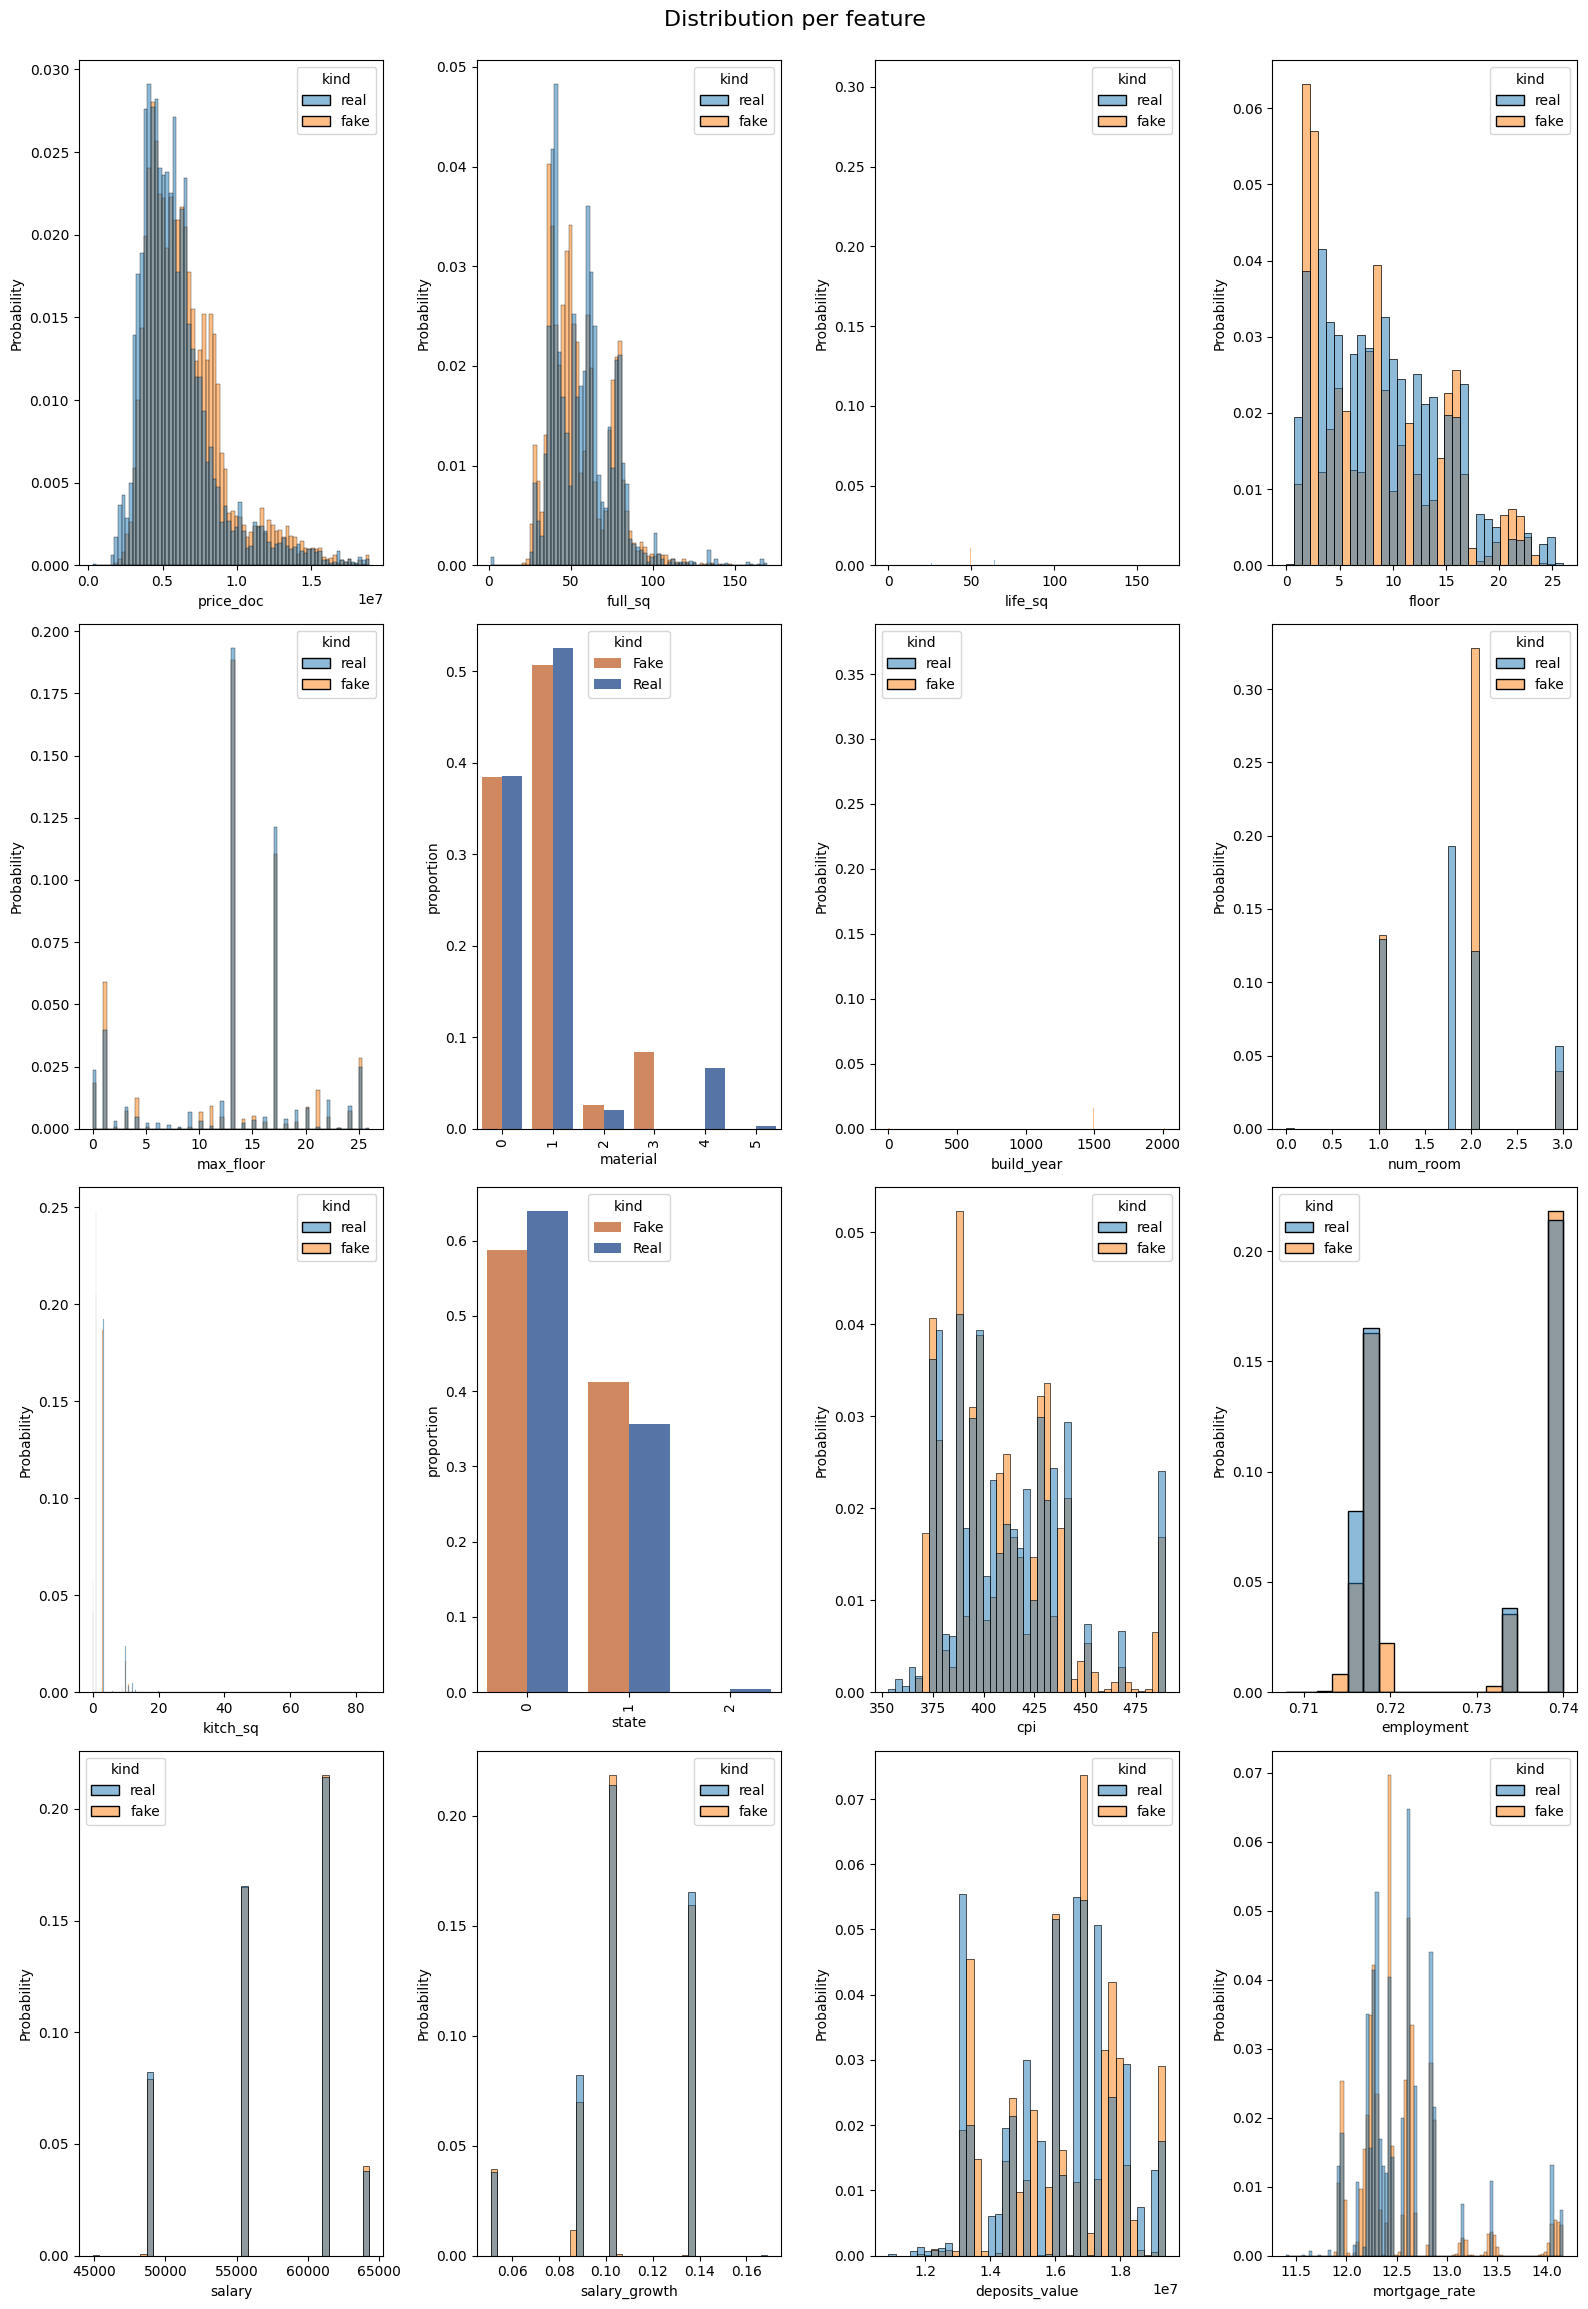

In [28]:
evaluator.plot_distributions(nr_cols=4)

## Save data

In [26]:
def save_data_csv(df: pd.DataFrame, path: str) -> None:
    """Saves the dataframe as CSV"""
    print(f"Saving data to path: `{path}`")
    df.to_csv(path, index=False)

In [27]:
if SAVE_DATA:
    save_data_csv(df_synth, PATH_SYNTH)